In [1]:
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
from ipyplot import plot_images
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

/home/pnoel/anaconda3/envs/sam2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bs=3

In [3]:
img = Image.open("/mnt/data/Objects365/images/train/objects365_v1_00000002.jpg") # Obj365 sample data
img_batch = [img]*bs # batch

In [31]:
w,h=img.size
w,h

(683, 512)

In [33]:
h,w,c = np.array(img).shape
(h,w,c)

(512, 683, 3)

In [25]:
from torchvision.io import read_image
img = read_image("/mnt/data/Objects365/images/train/objects365_v1_00000002.jpg")
img.shape # CHW

torch.Size([3, 512, 683])

In [2]:
!cat /mnt/data/Objects365/labels/train/objects365_v1_00000002.txt

2 0.47087 0.78686 0.19465 0.42629
2 0.36319 0.74360 0.15945 0.37292
2 0.26327 0.70907 0.09836 0.32320
6 0.36638 0.21641 0.03881 0.27089
6 0.46746 0.18150 0.03881 0.32386
6 0.60251 0.15935 0.04494 0.31730
9 0.52574 0.77504 0.49699 0.44992
12 0.57821 0.33405 0.16228 0.22649
12 0.67014 0.22206 0.14915 0.25026
12 0.75925 0.30402 0.05534 0.28655
12 0.88180 0.16396 0.23640 0.32642
12 0.06930 0.65475 0.12201 0.21073
12 0.27429 0.62748 0.07223 0.17769
12 0.05761 0.30777 0.08348 0.30407
12 0.24850 0.32404 0.07879 0.26903
12 0.16065 0.24198 0.12996 0.16148
26 0.03461 0.54132 0.03228 0.01984
76 0.69657 0.52441 0.03790 0.06587
81 0.67673 0.55090 0.11736 0.01719
94 0.34156 0.37293 0.04332 0.06381
122 0.03194 0.51175 0.03116 0.04618
133 0.88510 0.58936 0.21145 0.58608
134 0.18266 0.65327 0.12127 0.16861
149 0.16888 0.54692 0.14952 0.04320
201 0.16429 0.36145 0.14935 0.05423


#### Get all the images in training data, check list size

In [3]:
import os
img_list = [ i for i in os.listdir("/mnt/data/Objects365/images/train") if i.endswith(".jpg") ]

In [23]:
import sys
sz = sys.getsizeof(img_list)
g = sz//(1024**3)
m = sz//(1024**2) - 1024*g
k = sz//(1024) - 1024*m
print(f'{g} GB, {m} MB, {k} KB')

0 GB, 14 MB, 532 KB


In [16]:
img_list

['objects365_v1_00000000.jpg',
 'objects365_v1_00000002.jpg',
 'objects365_v1_00000003.jpg',
 'objects365_v1_00000004.jpg',
 'objects365_v1_00000005.jpg',
 'objects365_v1_00000006.jpg',
 'objects365_v1_00000009.jpg',
 'objects365_v1_00000010.jpg',
 'objects365_v1_00000012.jpg',
 'objects365_v1_00000013.jpg',
 'objects365_v1_00000014.jpg',
 'objects365_v1_00000017.jpg',
 'objects365_v1_00000018.jpg',
 'objects365_v1_00000019.jpg',
 'objects365_v1_00000020.jpg',
 'objects365_v1_00000022.jpg',
 'objects365_v1_00000023.jpg',
 'objects365_v1_00000024.jpg',
 'objects365_v1_00000026.jpg',
 'objects365_v1_00000028.jpg',
 'objects365_v1_00000029.jpg',
 'objects365_v1_00000031.jpg',
 'objects365_v1_00000032.jpg',
 'objects365_v1_00000033.jpg',
 'objects365_v1_00000034.jpg',
 'objects365_v1_00000035.jpg',
 'objects365_v1_00000036.jpg',
 'objects365_v1_00000038.jpg',
 'objects365_v1_00000039.jpg',
 'objects365_v1_00000040.jpg',
 'objects365_v1_00000041.jpg',
 'objects365_v1_00000042.jpg',
 'object

#### Dummy code for labels

In [4]:
w,h =img.size
lbl_origin = [0.26327,0.70907,0.09836,0.32320] # x,y,w,h where x,y is center
lbl = [int(lbl_origin[0]*w),int(lbl_origin[1]*h),int(lbl_origin[2]*w),int(lbl_origin[3]*h)]
lbl = [lbl[0]-lbl[2]/2, lbl[1]-lbl[3]/2, lbl[0]+lbl[2]/2, lbl[1]+lbl[3]/2]
img_lbls = [lbl]*bs

In [34]:
def xywh_rel_to_xyxy_abs(annot, image):
    _,w,h = image.shape # HWC
    # Now takes CWH
    # Convert relative to absolute
    annot[:,1::2], annot[:,2::2] = annot[:,1::2]*w, annot[:,2::2]*h
    # Convert xywh to xyxy (SAM's format)
    annot[:,1] = torch.round(annot[:,1] - annot[:,3]/2)
    annot[:,2] = torch.round(annot[:,2] - annot[:,4]/2)
    annot[:,3] = torch.round(annot[:,1] + annot[:,3]/2)
    annot[:,4] = torch.round(annot[:,2] + annot[:,4]/2)
    
    return annot.type(torch.int32)

In [40]:
img = read_image("/mnt/data/Objects365/images/train/objects365_v1_00300713.jpg")

In [41]:
img_lbls = xywh_rel_to_xyxy_abs(torch.tensor([[27, 0.68427, 0.22743, 0.02950, 0.06459],
                                   [48, 0.91560, 0.36759, 0.03318, 0.09045]]), 
                     img)
img_lbls

tensor([[ 27, 343, 134, 351, 156],
        [ 48, 460, 221, 468, 252]], dtype=torch.int32)

In [31]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image_batch([img]*2)
    masks, scores, _ = predictor.predict_batch(box_batch=img_lbls[1:])

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/pnoel/anaconda3/envs/sam2/lib/python3.10/site-packages/torch/nn/modules/container.py", line 250, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/home/pnoel/anaconda3/envs/sam2/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 277, in forward
            Tensor: Normalized Tensor image.
        """
        return F.normalize(tensor, self.mean, self.std, self.inplace)
               ~~~~~~~~~~~ <--- HERE
  File "/home/pnoel/anaconda3/envs/sam2/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 350, in normalize
        raise TypeError(f"img should be Tensor Image. Got {type(tensor)}")

    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
           ~~~~~~~~~~~~~ <--- HERE
  File "/home/pnoel/anaconda3/envs/sam2/lib/python3.10/site-packages/torchvision/transforms/_functional_tensor.py", line 928, in normalize
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    return tensor.sub_(mean).div_(std)
           ~~~~~~~~~~~ <--- HERE
RuntimeError: The size of tensor a (512) must match the size of tensor b (3) at non-singleton dimension 0


In [9]:
type(masks), masks[0].shape,len(masks)

(list, (3, 512, 683), 3)

In [10]:
import cv2
import matplotlib.pyplot as plt
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2)) 
    
def show_masks(image, masks, scores, box_coords=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

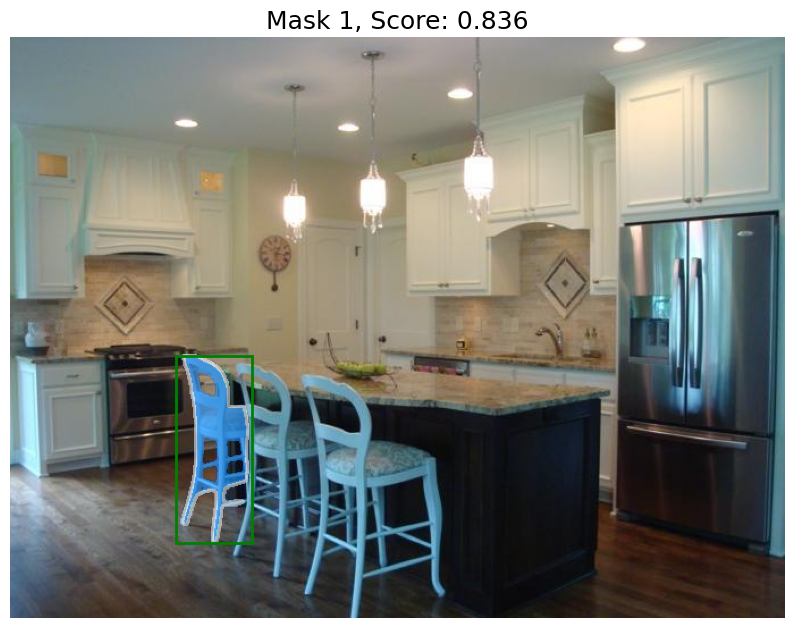

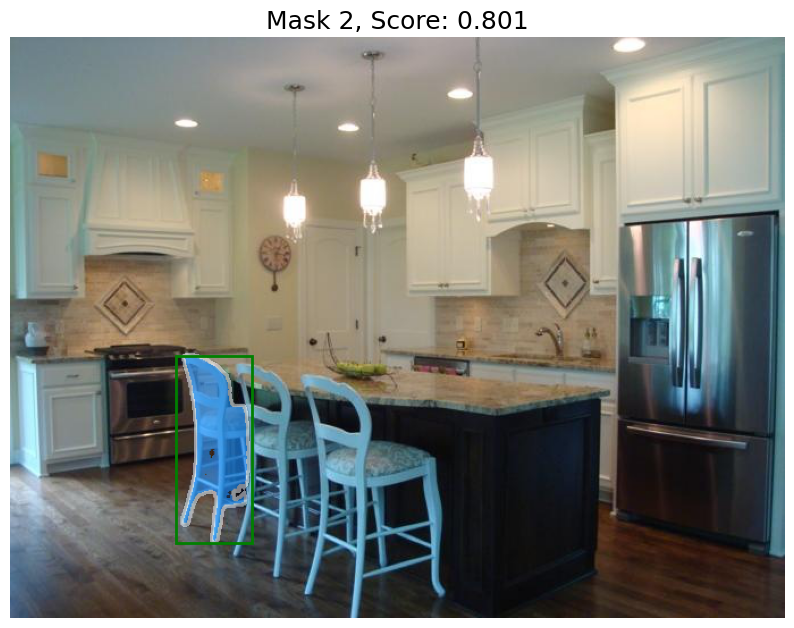

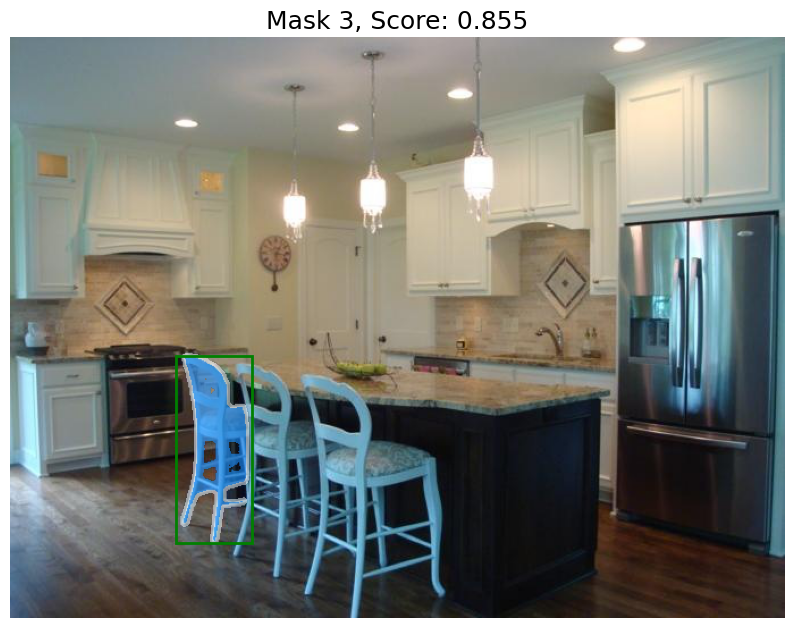

In [11]:
show_masks(img_batch[0], masks[0], scores[0], img_lbls[0])

In [12]:
masks = [np.transpose(mask,[1,2,0]) for mask in masks] # H, W, C
display_masks = [Image.fromarray((mask*255).astype("uint8")) for mask in masks]

Keep the union region of all the masks output by sam detector.

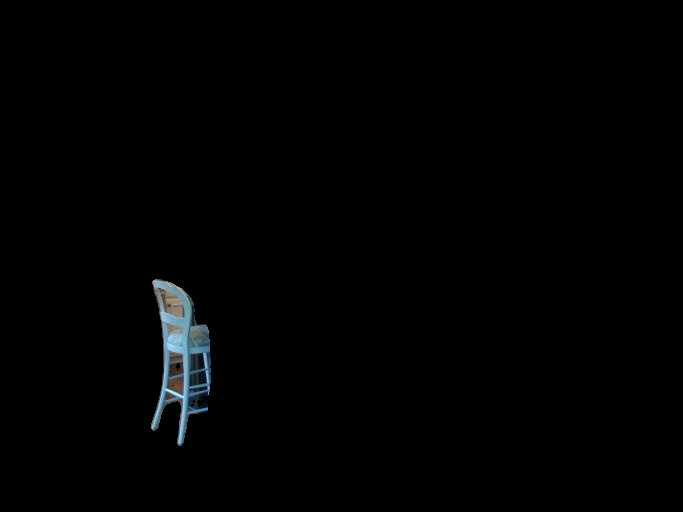

In [13]:
mask_1d = masks[0].mean(axis=2).astype('bool').astype('int')
img = np.repeat(mask_1d[:, :, np.newaxis], 3, axis=2) * img_batch[0] # Keep the union region of all the masks output by sam detector.
detection = Image.fromarray(img.astype('uint8'))
detection # HWC

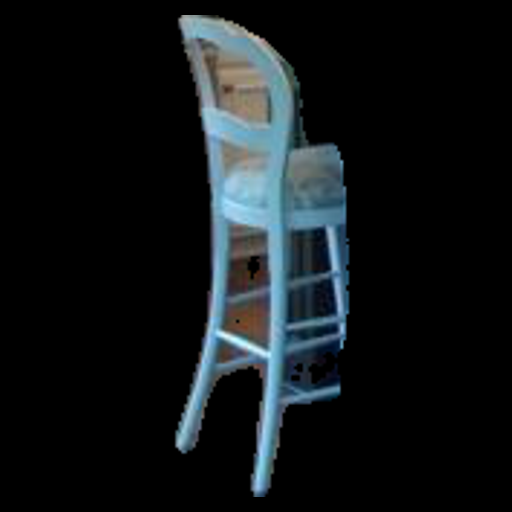

In [14]:
new_dim=512
padding=30

canvas = np.zeros((new_dim,new_dim,3))
# x,y, w, h = lbl_origin[0], lbl_origin[1], lbl_origin[2], lbl_origin[3]
crop_img = detection.crop(lbl)
w_crop,h_crop = crop_img.size

pad_dim = new_dim-padding

if w_crop>h_crop:
    w_new, h_new = pad_dim, int(h_crop*(pad_dim/w_crop))
    new_img = crop_img.resize((w_new, h_new))
    canvas[new_dim//2-h_new//2:new_dim//2+h_new//2+(h_new&1),padding//2:-(padding//2+(padding&1)),:] = new_img
else: # h occupies the axis=0
    w_new, h_new = int(w_crop*(pad_dim/h_crop)), pad_dim
    new_img = crop_img.resize((w_new, h_new))
    canvas[padding//2:-(padding//2+(padding&1)),new_dim//2-w_new//2:new_dim//2+w_new//2+(w_new&1),:] = new_img
img_final = Image.fromarray(canvas.astype('uint8'))
img_final

In [216]:
with open("demo/data/imgs/chair_sample.jpg", "wb") as f:
    img_final.save(f)